In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Menyiapkan dirtektori

In [ ]:
base_dir = '/content/drive/MyDrive/FOTO-FOTO GAJAH'
!ls "/content/drive/MyDrive/FOTO-FOTO GAJAH"

bahan  latih  validasi


In [ ]:
# menentukan direktori

bahan_dir = os.path.join(base_dir, 'bahan')
train_dir = os.path.join(base_dir, 'latih')
validation_dir = os.path.join(base_dir, 'validasi')

In [ ]:
# menentukan direktori isi bahan
Asian_dir = os.path.join(bahan_dir, 'Asian/')
African_dir = os.path.join(bahan_dir, 'African/')

print("Jumlah Data Train Tiap Kelas")
print('Jumlah gambar Gajah Asia :', len(os.listdir(Asian_dir)))
print('Jumlah gambar Gajah Afrika  :', len(os.listdir(African_dir)))


Jumlah Data Train Tiap Kelas
Jumlah gambar Gajah Asia : 420
Jumlah gambar Gajah Afrika  : 420


In [ ]:
# Direktori isi latih/training
train_Asian = os.path.join(train_dir, 'Asian/')
train_African = os.path.join(train_dir, 'African/')

# Direktori isi validasi
validation_Asian = os.path.join(validation_dir, 'Asian/')
validation_African = os.path.join(validation_dir, 'African/')


Menyiapkan Dataset

In [ ]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
    total_size = len(os.listdir(source))
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size

    randomized = random.sample(os.listdir(source), total_size)
    train_files = randomized[0:train_size]
    val_files = randomized[train_size:total_size]

    for i in train_files:
        i_file = source + i
        destination = train + i
        copyfile(i_file, destination)

    for i in val_files:
        i_file = source + i
        destination = val + i
        copyfile(i_file, destination)

# Jumlah pembagian data training dan testing
train_ratio = 0.9

# Pembagian Training dan Validasi
# Training
source_00 = Asian_dir
train_00 = train_Asian
val_00 = validation_Asian
train_val_split(source_00, train_00, val_00, train_ratio)

# Validasi
source_01 = African_dir
train_01 = train_African
val_01 = validation_African
train_val_split(source_01, train_01, val_01, train_ratio)


In [ ]:
print('Jumlah All Asian    :', len(os.listdir(Asian_dir)))
print('Jumlah Train Asian  :', len(os.listdir(train_Asian)))
print('Jumlah Val Asian    :', len(os.listdir(validation_Asian)))

Jumlah All Asian    : 420
Jumlah Train Asian  : 420
Jumlah Val Asian    : 216


Pre processing

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)


val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

target

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 840 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print('\nAkurasi mencapai 99%')
            self.model.stop_training = True

callbacks = myCallback()

Model CNN

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.3, seed=112),

    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=112),

    tf.keras.layers.Dense(2, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │       3,699,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 500)                 │         100,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           1,002 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,473,460 (43.77 MB)

 Trainable params: 3,824,486 (14.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,648,974 (29.18 MB)

In [ ]:
model.compile(loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = 80,
    epochs = 30,
    validation_data = val_generator,
    validation_steps = 1,
    verbose = 1,
    callbacks = [callbacks]
)

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 28s 349ms/step - accuracy: 0.5029 - loss: 0.6949 - val_accuracy: 0.7000 - val_loss: 0.6897
Epoch 2/30
 4/80 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.5354 - loss: 0.6920

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5255 - loss: 0.6917 - val_accuracy: 0.6000 - val_loss: 0.6910
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 304ms/step - accuracy: 0.5062 - loss: 0.6939 - val_accuracy: 0.6000 - val_loss: 0.6929
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5261 - loss: 0.6928 - val_accuracy: 0.6000 - val_loss: 0.6926
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 521ms/step - accuracy: 0.5302 - loss: 0.6930 - val_accuracy: 0.6000 - val_loss: 0.6904
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3485 - loss: 0.6973 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 542ms/step - accuracy: 0.5040 - loss: 0.6935 - val_accuracy: 0.6000 - val_loss: 0.6919
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5766 - loss: 0.6917 - val_accuracy: 0.4000 - val_loss: 0.6940
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - accuracy: 0.5056 - loss: 0.6935 - val_accuracy: 0.6000 - val_

tingkat akurasi dan loss model

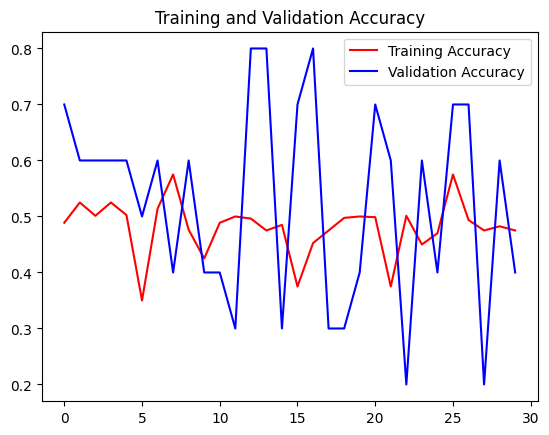

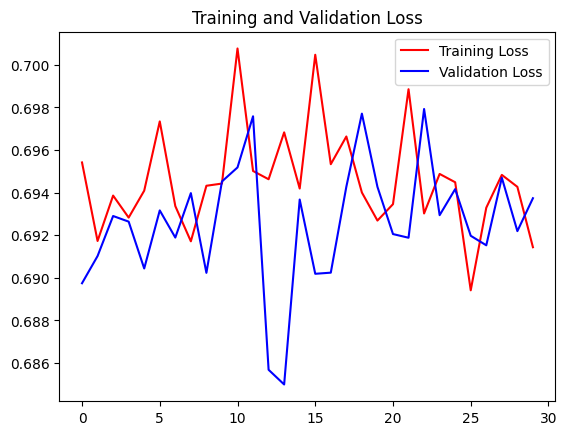

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.show()


coba kalasifikasi

Saving as_tr92.jpg to as_tr92 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
as_tr92 (1).jpg
This image belongs to class Asian


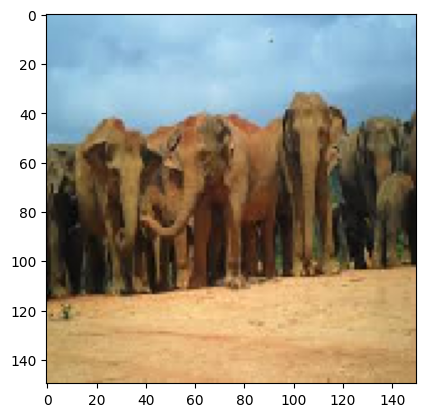

In [ ]:
import numpy as np
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():


    path = fn
    img = image.load_img(path, target_size=(150, 150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=100)

    print(fn)

    class_list = os.listdir(train_dir)

    for j in range(len(class_list)):
      if classes[0][j] == max(classes[0]):
        print('This image belongs to class', class_list[j])
        break